# Intro to Keras
## With a discussion of hyperparameter tuning

Richard Corrado richcorrado.github.io April 2017
For the Fat Cat Fab Lab Machine Learning Meetup

Keras https://keras.io/ is a high-level Python API for constructing, training and using neural networks.  It can run on top of TensorFlow https://www.tensorflow.org/ or Theano http://www.deeplearning.net/software/theano/.  Beginning with version 1.1, the TensorFlow distribution includes Keras in the contributed modules.  For convenience, we will be using this version of Keras, instead of the independent distribution that remains available on github and PyPI.  Therefore, please verify that your local version of TensorFlow (TF) is v. 1.1 or above. 

Note: If you have an interest in using Theano as the backend for Keras, you will want to install the main distribution of Keras from the repo  https://github.com/fchollet/keras.

In [1]:
import tensorflow as tf

In [2]:
tf_ver = tf.__version__
tf_ver_split = tf_ver.split(".")
maj_min_ver = tf_ver_split[0] + '.' + tf_ver_split[1]
maj_min_ver = float(maj_min_ver)

if maj_min_ver >= 1.1:
    print("Installed version ", tf_ver, " includes Keras!")
else:
    print("!!!!!!!   Installed version ", tf_ver, " does not include Keras! !!!!!!!")

Installed version  1.1.0  includes Keras!


Please refer to the documentation at https://www.tensorflow.org/install/ to upgrade your local version if necessary.

In the meantime, we'll load numpy and matplotlib, since we'll be using them extensively later.

In [3]:
import numpy as np

import matplotlib
# this is needed for interactive plots to be displayed properly
matplotlib.use('Agg')
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from matplotlib import pyplot
rcParams['figure.figsize'] = 12, 4
# allow interactive plots
%matplotlib notebook

### A simulated data set

We'll also generate a simulated dataset for our first Keras model.  We'll set a random seed for numpy, since we'll be basing our simulated dataset on various types of random variables.  

In [4]:
np.random.seed(279)

In this case, we'll draw training and valididation arrays from a uniform distribution on the unit interval:

In [92]:
n_train = 20000
n_test = 2000
n_feat = 20

In [93]:
x_train = np.random.uniform(0, 1, (n_train, n_feat))
x_test = np.random.uniform(0, 1, (n_test, n_feat))

For the target, we'll compose a nontrivial function. 
$$ f(\mathbf{x})  = \mathbf{a} \cdot \mathbf{x} + (\mathbf{b} \cdot \mathbf{x})^3 + c + \epsilon, $$

where $\epsilon$ is a random error. We'll choose $a$ as a fixed random vector

In [94]:
a_f = np.random.uniform(0, 1, n_feat)

The vector $b$ will be nonzero only over the first 5 features

In [95]:
b_f = np.random.uniform(0, 1, 5)
b_f = np.pad(b_f, (0, n_feat-5), 'constant', constant_values=(0, 0))

The intercept will also be random:

In [96]:
c_f = np.random.uniform(0, 1, 1)

We'll explicitly define our function, which acts on 20d vectors

In [97]:
def f_def(x):
    y = np.dot(a_f, x)
    y += (np.dot(b_f, x))**3
    y += c_f
    return y

In [98]:
y_train = np.apply_along_axis(f_def, 1, x_train).reshape(-1) + np.random.normal(scale=0.1, size=n_train)
y_test = np.apply_along_axis(f_def, 1, x_test).reshape(-1) + np.random.normal(scale=0.1, size=n_test)

In [12]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(20000, 20)
(20000,)
(2000, 20)
(2000,)


### Ordinary Least Squares  Benchmark

As a benchmark, we'll use least squares from sklearn to fit the data.

In [13]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

regr.fit(x_train, y_train)

y_ols = regr.predict(x_train)
y_test_ols = regr.predict(x_test)

We can use numpy functions to obtain the mean squared error (MSE) on the training and validation data:

In [14]:
np.mean(np.square(y_ols - y_train))

0.087210337191664183

In [15]:
np.mean(np.square(y_test_ols - y_test))

0.084115335162392932

## A simple NN with Keras

The Keras docs include a "30 seconds to Keras" intro https://keras.io/#getting-started-30-seconds-to-keras. We'll follow partly along with that example, but modify it for the simulated data above, which is a regression problem.

Since we are using the version that comes with TensorFlow, we don't need to do additional imports of the Keras classes, but we do need to specify the appropriate prefix `tf.contrib.keras.` To use the `Sequential` model, which provides a linear stack of layers, appropriate for many applications including pure feedforward networks, we assign

In [16]:
model =  tf.contrib.keras.models.Sequential()

### Adding the layers

Keras is built around applying methods to its model classes, much the same way as sklearn. To add a layer, we can use the `.add` method. We will add a `Dense`, or fully-connected, layer, so we run

In [17]:
model.add(tf.contrib.keras.layers.Dense(units=64, input_dim=n_feat))

Note the `units` flag to set the width of the layer. Since this was the first layer in our network, it was also necessary to specify the `input_dim` flag so that Keras will also generate an appropriate input layer.  We have used the variable `n_feat` for our simulated dataset.  Further options for the layer classes are documented at https://keras.io/layers/core/

We can specify an activation function for this layer by adding

In [18]:
model.add(tf.contrib.keras.layers.Activation('relu'))

Our simulated data is a regression problem for a single target, so we will define an appropriate output layer

In [19]:
model.add(tf.contrib.keras.layers.Dense(units=1))

We won't include an activation function since this layer is performing linear regression on the features computed in the hidden layer.  A short-hand graph of our network is:

![single_hidden_layer](shl.png)

### Defining the learning process

The learning process is specified with the `.compile` method. 

In [20]:
model.compile(loss='mean_squared_error',
              optimizer='sgd')

If we want to exercise greater control over the hyperparameters of the optimizer, we can do that as well:

In [21]:
model.compile(loss='mean_squared_error',
              optimizer=tf.contrib.keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True))

### Training the model

Training the model uses a `.fit` method, just as in sklearn.

In [22]:
model.fit(x_train, y_train, epochs=20, batch_size=200)

Epoch 1/20
20000/20000 [==============================] - 0s - loss: 1.1302     
Epoch 2/20
20000/20000 [==============================] - 0s - loss: 0.1001     
Epoch 3/20
20000/20000 [==============================] - 0s - loss: 0.0801     
Epoch 4/20
20000/20000 [==============================] - 0s - loss: 0.0647     
Epoch 5/20
20000/20000 [==============================] - 0s - loss: 0.0498     
Epoch 6/20
20000/20000 [==============================] - 0s - loss: 0.0370     
Epoch 7/20
20000/20000 [==============================] - 0s - loss: 0.0289     
Epoch 8/20
20000/20000 [==============================] - 0s - loss: 0.0243     
Epoch 9/20
20000/20000 [==============================] - 0s - loss: 0.0214     
Epoch 10/20
20000/20000 [==============================] - 0s - loss: 0.0200     
Epoch 11/20
20000/20000 [==============================] - 0s - loss: 0.0187     
Epoch 12/20
20000/20000 [==============================] - 0s - loss: 0.0178     
Epoch 13/20
20000/20000 [

The `.fit` method gives an active graphical representation of the progress, along with loss and metric values.  To suppress the logs, `.fit` takes a `verbose=0` flag. In order to prevent updating the line during each batch, but still print the loss each epoch, use `verbose=2`.

### Evaluating the model

To get the loss and metrics on a validation set, we can use the `.evaluate` method, which supports batch processing as well:

In [23]:
model.evaluate(x_train, y_train, batch_size=200)

 9400/20000 [=============>................] - ETA: 0s

0.01518854409456253

In [24]:
model.evaluate(x_test, y_test, batch_size=200)

 200/2000 [==>...........................] - ETA: 0s

0.016844949405640363

These results are much better than the 0.08 MSE of the OLS model benchmark.  It is possible that we could do even better by tuning the model.  Later in the notebook, we'll see some methods that are useful for tuning models.

### Predicting with the model

Model predictions can be obtained via the `.predict` method, again as in sklearn:

In [25]:
y_train_pred = model.predict(x_train, batch_size=200).reshape(-1)

Here we used the numpy `.reshape()` method to obtain a column vector:

In [26]:
model.predict(x_train, batch_size=200).shape

(20000, 1)

In [27]:
y_train_pred.shape

(20000,)

We similarly make predictions on the validation set:

In [28]:
y_pred = model.predict(x_test, batch_size=200).reshape(-1)

As a check, we can compute the mean squared error via numpy functions:

In [29]:
np.mean(np.square(y_train_pred - y_train))

0.01518854375415458

In [30]:
np.mean(np.square(y_pred - y_test))

0.016844951120868798

These agree with the results of `.evaluate` to a high accuracy.

### Including validation metrics

Typically, during training, we're also interested in how our validation metrics are changing. Keras allows us to pass `validation_data` to the `.fit` method:

In [31]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=200)

Train on 20000 samples, validate on 2000 samples
Epoch 1/20
20000/20000 [==============================] - 0s - loss: 0.0145 - val_loss: 0.0153
Epoch 2/20
20000/20000 [==============================] - 0s - loss: 0.0143 - val_loss: 0.0149
Epoch 3/20
20000/20000 [==============================] - 0s - loss: 0.0144 - val_loss: 0.0146
Epoch 4/20
20000/20000 [==============================] - 0s - loss: 0.0142 - val_loss: 0.0147
Epoch 5/20
20000/20000 [==============================] - 0s - loss: 0.0142 - val_loss: 0.0144
Epoch 6/20
20000/20000 [==============================] - 0s - loss: 0.0139 - val_loss: 0.0159
Epoch 7/20
20000/20000 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0140
Epoch 8/20
20000/20000 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0139
Epoch 9/20
20000/20000 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0150
Epoch 10/20
20000/20000 [==============================] - 0s - loss: 0.0134 - val_loss: 0.0136


### Reinitializing weights

Note that this additional call of `.fit` did not reset the weights from the previous training call.  Instead this training cylce begins with the weights generated in the previous training and tries to optimize further. 

Currently there is no built-in function to reinitialize the the weights of a model.  One workaround by jkleint https://gist.github.com/jkleint/eb6dc49c861a1c21b612b568dd188668 involves shuffling the existing weights.  Here we modify that code to reinitialize the weights with random values.   In some problems, you might be using a more sophisticated weight initialization scheme (see https://keras.io/initializers/ for some of the ones built-in to Keras).  In that case, you would want to modify the code below to use that scheme.

In [32]:
import scipy.stats as stats

In [33]:
def randomize_weights(model, weights=None, random_state=None):
    """Reinitialize the weights in `model`, or the given `weights`.
    New weight parameters are drawn from a truncated normal distribution.
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [stats.truncnorm.rvs(0, 1, scale=0.1, size=w.flatten().shape, random_state=random_state).reshape(w.shape) 
               for w in weights]
    model.set_weights(weights)

In [34]:
randomize_weights(model, random_state=475)

In [35]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=200)

Train on 20000 samples, validate on 2000 samples
Epoch 1/20
20000/20000 [==============================] - 0s - loss: 0.6144 - val_loss: 0.0681
Epoch 2/20
20000/20000 [==============================] - 0s - loss: 0.0570 - val_loss: 0.0575
Epoch 3/20
20000/20000 [==============================] - 0s - loss: 0.0377 - val_loss: 0.0301
Epoch 4/20
20000/20000 [==============================] - 0s - loss: 0.0260 - val_loss: 0.0253
Epoch 5/20
20000/20000 [==============================] - 0s - loss: 0.0218 - val_loss: 0.0198
Epoch 6/20
20000/20000 [==============================] - 0s - loss: 0.0187 - val_loss: 0.0181
Epoch 7/20
20000/20000 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0164
Epoch 8/20
20000/20000 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0160
Epoch 9/20
20000/20000 [==============================] - 0s - loss: 0.0149 - val_loss: 0.0153
Epoch 10/20
20000/20000 [==============================] - 0s - loss: 0.0141 - val_loss: 0.0143


Before moving on to different models and topics, we should note that Keras also supports training via explicitly defined batches.  For instance, suppose that we want to use the sklearn KFold generator to produce our batches.  We can use the `.train_on_batch` method in a `for` loop.

Let's reinitialize the weights and import the KFold CV generator from sklearn.

In [36]:
randomize_weights(model, random_state=475)

from sklearn.model_selection import KFold

We have to use the size of the training set and specify the batch size in order to figure out the total number of batches we need. 

In [100]:
batch_size = 200
total_batch = int(n_train / batch_size)
total_batch

100

We then pass the total number of batches as splits to KFold:

In [38]:
kfold = KFold(n_splits=total_batch, shuffle=True, random_state=488)

We use the leave-out fold as the batch set.  We can control the verbosity of the logs displayed with the `display_step` variable.

In [39]:
n_epoch = 20
display_step = 5

for epoch in range(1, n_epoch+1):
    for _, batch_idx in kfold.split(x_train, y_train):
            x_batch, y_batch = x_train[batch_idx], y_train[batch_idx]
            model.train_on_batch(x_batch, y_batch)
    
    if epoch % display_step == 0:
        train_loss = model.evaluate(x_train, y_train, batch_size=128, verbose=0)
        print("For epoch", epoch, "/", n_epoch, "training loss is: ", train_loss)
        val_loss = model.evaluate(x_test, y_test, batch_size=128, verbose=0)
        print("Validation loss is: ", val_loss)
    

For epoch 5 / 20 training loss is:  0.0187990192816
Validation loss is:  0.0197616390288
For epoch 10 / 20 training loss is:  0.0130946438998
Validation loss is:  0.0140230330676
For epoch 15 / 20 training loss is:  0.0116797312811
Validation loss is:  0.0124275151193
For epoch 20 / 20 training loss is:  0.0110472275198
Validation loss is:  0.0116644329876


Keras also provides a `.fit_generator` method that allows you to provide a custom python generator.  The generator must provide an infinite sequence of batches.  We'll use this method later in the notebook, when we use a generator that Keras provides for handling image data.

## Cross-Validation with Keras

The main factor that slightly complicates implementing cross-validation with Keras is the way that the weights are defined as an integral part of the model.  This is partly the design of Keras and partly that of TensorFlow and, in either case, makes a lot of sense.  The method for handling this is to simply define a series of models, either in parallel at the beginning of an experiment or in an appropriate loop as part of the iteration over the $K$ train/test splits.   

We will continue working with the same simulated data and redefine our `kfold` generator to do 10-fold CV:

In [40]:
n_fold = 10
kfold = KFold(n_splits=n_fold, shuffle=True, random_state=84)

We will explicitly iterate over the CV splits, but let the Keras classes handle the batching on their own:

In [41]:
# training parameters
n_epoch = 20
batch_size = 200

# create a list to store the CV scores
CVscores = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(x_train, y_train)):
  # create model
    print("Creating model for fold ", fold+1)
    model = None # clear any previous model
    model =  tf.contrib.keras.models.Sequential()
    model.add(tf.contrib.keras.layers.Dense(units=64, input_dim=n_feat))
    model.add(tf.contrib.keras.layers.Activation('relu'))
    model.add(tf.contrib.keras.layers.Dense(units=1))
    model.compile(loss='mean_squared_error',
                  optimizer=tf.contrib.keras.optimizers.Adam(lr=0.01))
    # Fit to CV train fold
    model.fit(x_train[train_idx], y_train[train_idx], 
              epochs=n_epoch, batch_size=batch_size, verbose=0)
    # Evaluate on CV test fold
    score = model.evaluate(x_train[test_idx], y_train[test_idx], 
                           batch_size=batch_size, verbose=0)
    CVscores.append(score)
    print("For fold ", fold+1, " validation MSE: ", score)

CVmean = np.mean(CVscores)
CVstd = np.std(CVscores)
CVpct = 100 * CVstd / CVmean
print("For " + str(n_fold) + "-fold CV, avg MSE: " + format(CVmean, '.4f') +
      ", std dev of MSE: " + format(CVstd, '.4f') +
     " (" + format(CVpct, '.2f') + "%)")

Creating model for fold  1
For fold  1  validation MSE:  0.0188219176605
Creating model for fold  2
For fold  2  validation MSE:  0.0249143116176
Creating model for fold  3
For fold  3  validation MSE:  0.0166026607156
Creating model for fold  4
For fold  4  validation MSE:  0.0187602807768
Creating model for fold  5
For fold  5  validation MSE:  0.0149140250869
Creating model for fold  6
For fold  6  validation MSE:  0.0182466682047
Creating model for fold  7
For fold  7  validation MSE:  0.0176419820637
Creating model for fold  8
For fold  8  validation MSE:  0.013991618529
Creating model for fold  9
For fold  9  validation MSE:  0.0181277332827
Creating model for fold  10
For fold  10  validation MSE:  0.0180129392073
For 10-fold CV, avg MSE: 0.0180, std dev of MSE: 0.0028 (15.39%)


Note: While using the SGD optimizer, I found it common to find NaN values for the loss, reflecting some problem with large gradients, the choice of learning rate, or other poor choices for the training parameters.  In some cases, I could avoid this by choosing a larger batch size.  To avoid future issues, I have switched to using the Adam optimizer in this example.

## Hyperparameter Tuning

Practically all machine learning algorthms involve certain parameters that help to control the capacity of the model to learn information from the training data.   In order to distinguish these from the parameters that are tuned during the learning process in parametric models, we refer to the first type of parameters as **hyperparameters**.  To be clearer, we use the terminology

* **Parameter**:  A variable that is tuned during the training process in such a way to minimize a loss function.  Examples of parameters are:
   - The slope and intercept coefficients of a generalized linear model. 
   - The weights and biases of a neural network.
   
If we wanted to be more specific, we could call these **model parameters**.  A given model has a fixed number of such parameters: a linear model has a slope for every feature and a single intercept parameter.   If we include additional coefficients for polynomial powers of the features, we have a different linear model.

* **Hyperparameter**: A quantity that is fixed before the training process to help define the exact model or learning method being used.  Examples of hyperparameters are:
    - The number of coefficient parameters included in a linear model: i.e., coefficients for terms linear in the features, quadratic in features, etc.
    - The width of a NN hidden layer.  Again this hyperparameter tunes the number of model parameters since the width determines the number of weights needed.
    - The number of NN hidden layers, or depth.  
    - The learning rate used in a gradient descent algorithm.  This controls the rate of learning and whether the learning process will be convergent.
    
Hyperparameters can be thought of as values that you tune within a **class of models**.  For example, fully-connected feedforward NNs (multilayer perceptrons) are a class of ML models.  Specific models in this class are labeled by the depth and hidden layer widths.   Similarly the learning rate determines the exact form of gradient descent one is applying, though use of a different learning rate is still within the class of gradient descent algorithms.

Now, an important technique in machine learning is the statistical framework of training model parameters on a training dataset and then testing the trained model on a validation dataset that was not involved in the training process.   By computing relevant metrics, one can **discover serious problems** with a model, such as **overfitting** (validation error much larger than training error).  One can also compare the errors produced by different models, allowing for **model selection**.

Since we want to preserve a validation set that has not influenced our modeling and training process, we would like to select hyperparameters from testing on the training data alone.  Therefore we should make a further split of our training data into another hyperparameter validation set.  Often the best practice is to use 5-10-fold cross-validation on the training set to determine optimal hyperparameters.  

However, while this ensures that we have done computations on sample sets that are representative of the total training population,  it does involve significant computational overhead.  With deep NNs, a single model might take hours or days to fully train.  CV over grids of possible hidden layer widths alone might take weeks. 

* For instance, if we have 7 dense layers and want to test 10 values of width for each of them, that is a grid of $10^7$, or 10 million, individual models.  Even if it takes only a minute to train each model, it would still take almost 20 years to do a grid search over all of these points.

Therefore it might not be possible for every project to fully explore all ranges of hyperparameters using a **grid search**. 

Two partial solutions to this problem stand out.  The first is to stay aware of previous approaches to problems in your class and start with a architecture that was promising for a related problem.   The second is called **random search**, and involves: 

**Random Search Algorithm**
1. Define the domain for each hyperparameter over which to search.
2. Define an appropriate statistical distribution over each domain.  This could be uniform, or another type of distribution that favors a region of particular interest.
3. Draw a number of random tuples from the resulting joint distribution. This number is typically $\mathcal{O}(10^{1-2})$, as opposed to the much larger number $\mathcal{O}((\text{grid size})^n)$ needed for grid search.
4. Run full CV over the training set for each tuple of hyperparameters.
5. Select the tuple of hyperparameters that resulted in the best CV metrics.

Random search does not search for the optimal point in hyperparameter space, but instead looks for a point that results in a nearly optimal error.  It is possible to do some amount of grid search around the solution found by random search, but gains are usually small.  We will investigate this a bit below.

## Grid search and the Learning Process

Before getting into the details of random search, we should explore the learning process in more detail.  In the model studied above, we really didn't pay too much attention to the parameters like batch size, learning rate or number of training epochs.   Let's see how these parameters affect the learning process and the errors of the trained model.

### Training Epochs and Early Stopping

The first hyperparameter we'll look at is the number of training epochs. 
* If the number of training epochs is too small, the model will not have had an opportunity to learn all of the information contained in the training data.  The training error will be suboptimal if addtional training could have reduced the error.
* If the number of training epochs is too large, there are a a couple of possibilities:
    - The training error might not have improved significantly in later epochs, so time was wasted.  One should test whether changing the learning rate results in an improvement of the loss in later epochs.
    - The training error might have continued to improve, but the additional training has led to overfitting, so that the validation error has increased. It is important to include validation error among the metrics that one computes and displays during training in order to quickly notice overfitting.
    
Preventing a model from overfitting by reducing the number of training epochs is a regularization technique known as **early stopping**.  Keras provides a **callback** function to the `.fit` method called `EarlyStopping` https://keras.io/callbacks/#earlystopping that will monitor a quantity like a loss or metric and end training if the value has not improved by a specified tolerance named `min_delta` within a number of training epochs called `patience`.  

Typically one needs to examine the training process and how the loss is changing in order to determine a good value for the tolerance to use in early stopping. A convenient way to do this is provided by the Keras `History` callback https://keras.io/callbacks/#history.  This callback is automatically applied to every Keras model and is returned by the `.fit` method.  Let's examine how to use this:  

In [42]:
n_epoch = 10
batch_size = 200

model = None # clear any previous model
model =  tf.contrib.keras.models.Sequential()
model.add(tf.contrib.keras.layers.Dense(units=64, input_dim=n_feat))
model.add(tf.contrib.keras.layers.Activation('relu'))
model.add(tf.contrib.keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error',
              optimizer=tf.contrib.keras.optimizers.Adam(lr=0.01))
hist = model.fit(x_train, y_train, 
                 validation_data=(x_test, y_test),
                 epochs=n_epoch, batch_size=batch_size, verbose=0)

In [43]:
print(hist.history)

{'loss': [3.2508828768134119, 0.22195745326578617, 0.11948378540575505, 0.10325071454048157, 0.091828224584460258, 0.083268665112555026, 0.074294293597340577, 0.063321493454277511, 0.053710409067571165, 0.044827454201877115], 'val_loss': [0.3507843017578125, 0.13049621507525444, 0.10628919005393982, 0.094568548351526255, 0.083315695077180868, 0.075193629786372188, 0.066071145981550214, 0.056929168850183488, 0.048790454119443896, 0.041214693710207938]}


So the `.history` method returns a dictionary with the per epoch values of the loss and any other metrics included in the `.compile` call.   Let's run the model for a large number of epochs and analyze the result:

In [44]:
n_epoch = 100
batch_size = 200

model = None # clear any previous model
model =  tf.contrib.keras.models.Sequential()
model.add(tf.contrib.keras.layers.Dense(units=64, input_dim=n_feat))
model.add(tf.contrib.keras.layers.Activation('relu'))
model.add(tf.contrib.keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error',
              optimizer=tf.contrib.keras.optimizers.Adam(lr=0.01))
hist = model.fit(x_train, y_train,  
                 validation_data=(x_test, y_test),
                 epochs=n_epoch, batch_size=batch_size, verbose=0)

In [45]:
loss_vec = (hist.history)['loss']
val_loss_vec = (hist.history)['val_loss']
print(len(loss_vec))

100


<IPython.core.display.Javascript object>


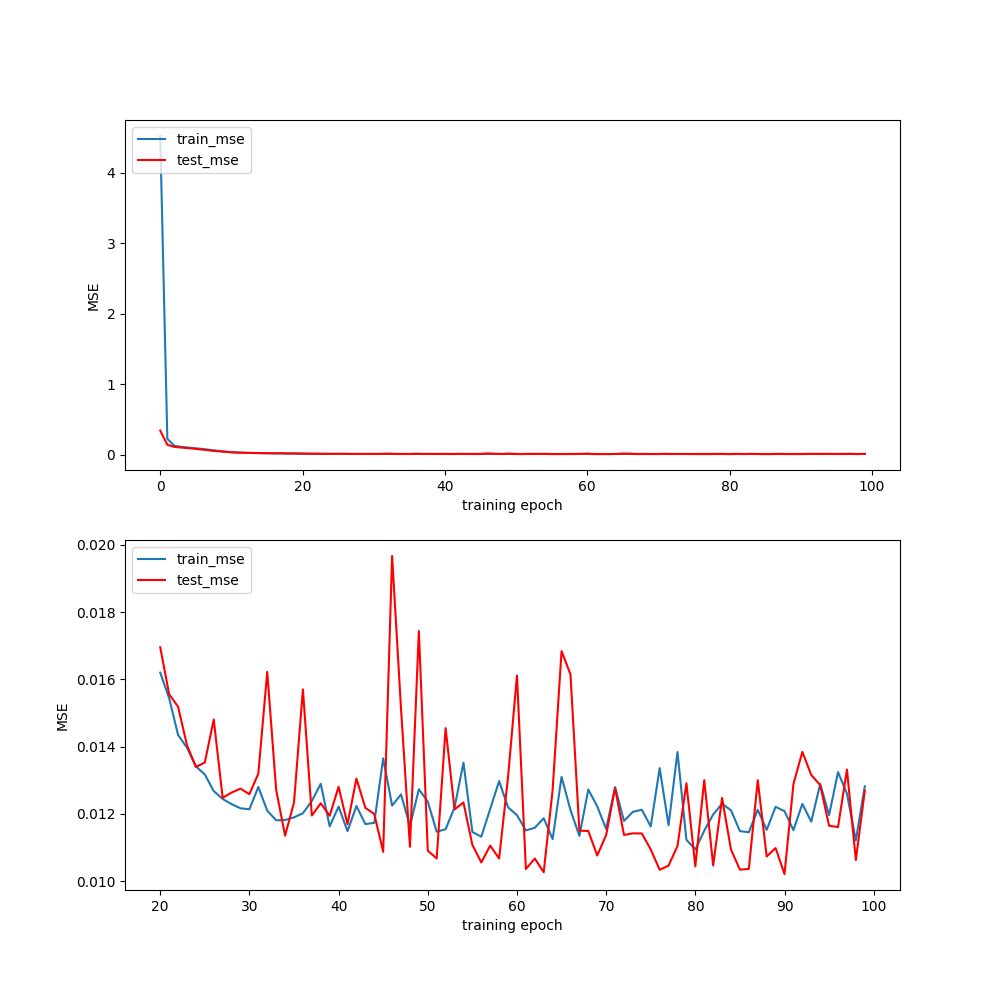

In [46]:
fig, ax = plt.subplots(2,1, figsize=(10, 10))

cutoff = 20

ax[0].plot(range(n_epoch), loss_vec, label='train_mse')
ax[0].plot(range(n_epoch), val_loss_vec, c='r', label='test_mse')
ax[0].set_xlabel('training epoch')
ax[0].set_ylabel('MSE')
ax[0].legend(loc='upper left')

ax[1].plot(range(cutoff,n_epoch), loss_vec[cutoff:], label='train_mse')
ax[1].plot(range(cutoff,n_epoch), val_loss_vec[cutoff:], c='r', label='test_mse')
ax[1].set_xlabel('training epoch')
ax[1].set_ylabel('MSE')
ax[1].legend(loc='upper left')

plt.show()

The fluctuations in the training loss around epoch 30 suggests that the learning rate is too large.  Let's decrease the learning rate and replot the loss:

In [59]:
n_epoch = 400
batch_size = 200
learning_rate = 0.001

model = None # clear any previous model
model =  tf.contrib.keras.models.Sequential()
model.add(tf.contrib.keras.layers.Dense(units=64, input_dim=n_feat))
model.add(tf.contrib.keras.layers.Activation('relu'))
model.add(tf.contrib.keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error',
              optimizer=tf.contrib.keras.optimizers.Adam(lr=learning_rate))
hist = model.fit(x_train, y_train, 
                 validation_data=(x_test, y_test),
                 epochs=n_epoch, batch_size=batch_size, verbose=0)

In [60]:
loss_vec = (hist.history)['loss']
val_loss_vec = (hist.history)['val_loss']
print(len(loss_vec))

400


<IPython.core.display.Javascript object>


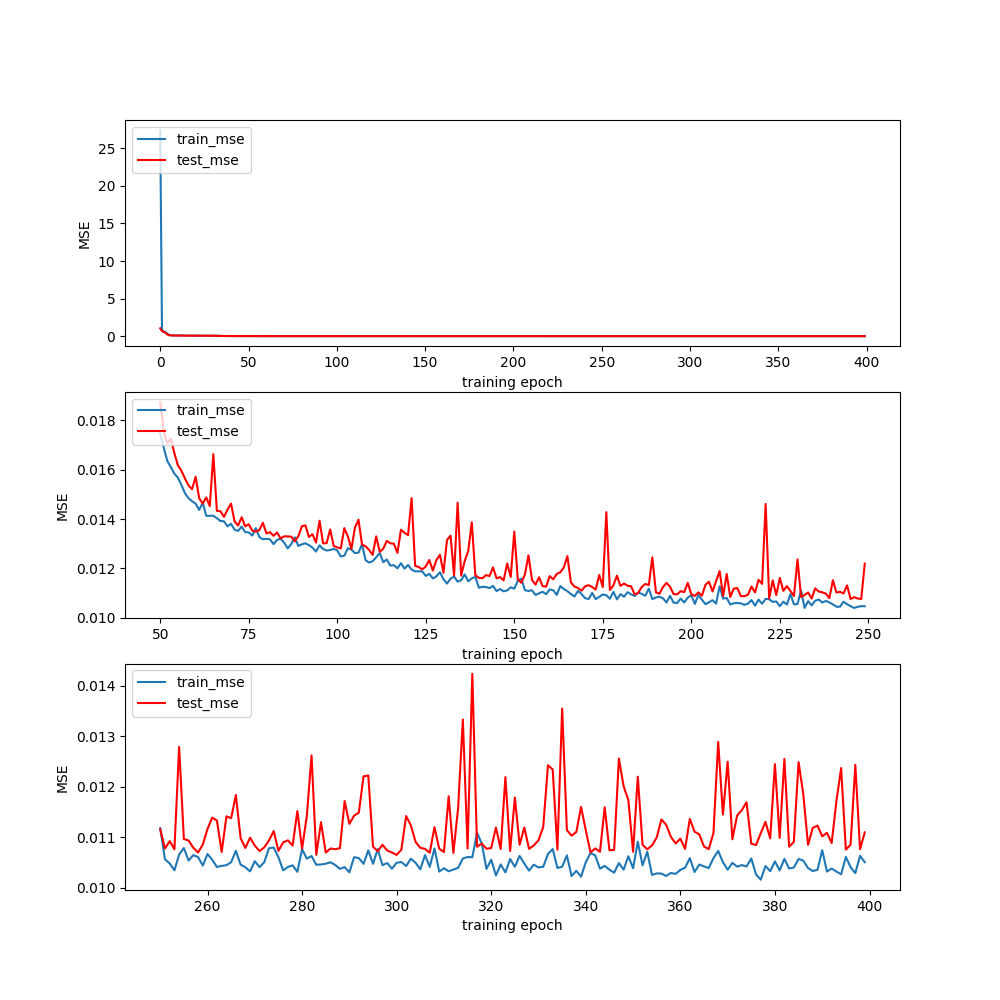

In [61]:
fig, ax = plt.subplots(3,1, figsize=(10, 10))

cutoff1 = 50
cutoff2 = 250

ax[0].plot(range(n_epoch), loss_vec, label='train_mse')
ax[0].plot(range(n_epoch), val_loss_vec, c='r', label='test_mse')
ax[0].set_xlabel('training epoch')
ax[0].set_ylabel('MSE')
ax[0].legend(loc='upper left')

ax[1].plot(range(cutoff1,cutoff2), loss_vec[cutoff1:cutoff2], label='train_mse')
ax[1].plot(range(cutoff1,cutoff2), val_loss_vec[cutoff1:cutoff2], c='r', label='test_mse')
ax[1].set_xlabel('training epoch')
ax[1].set_ylabel('MSE')
ax[1].legend(loc='upper left')

ax[2].plot(range(cutoff2,n_epoch), loss_vec[cutoff2:], label='train_mse')
ax[2].plot(range(cutoff2,n_epoch), val_loss_vec[cutoff2:], c='r', label='test_mse')
ax[2].set_xlabel('training epoch')
ax[2].set_ylabel('MSE')
ax[2].legend(loc='upper left')

plt.show()

The spiky nature of the plot suggests that the system is not finding a true minimum, but that gradient descent is pushing the parameters around, perhaps ocassionally finding a local minimum.  In particular, we can't assume that any point patch 100 epochs will have a low test error, because there is up to 50% variation.  It is possible that adjusting the learning error will reduce this spikiness.

Let's use `EarlyStopping` to terminate training if more than 2 epochs have passed with no improvement in the training loss:

In [62]:
n_epoch = 400
batch_size = 200
learning_rate = 0.001
patience = 2

optimizer=tf.contrib.keras.optimizers.Adam(lr=learning_rate)
callbacks = [tf.contrib.keras.callbacks.EarlyStopping(monitor='loss', 
                                                      patience=patience, verbose=0)]

model = None # clear any previous model
model =  tf.contrib.keras.models.Sequential()
model.add(tf.contrib.keras.layers.Dense(units=64, input_dim=n_feat))
model.add(tf.contrib.keras.layers.Activation('relu'))
model.add(tf.contrib.keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error',
              optimizer=optimizer)
hist = model.fit(x_train, y_train, 
                 validation_data=(x_test, y_test),
                 epochs=n_epoch, batch_size=batch_size, verbose=0,
                 callbacks = callbacks)

In [65]:
print(len(hist.history['val_loss']))
print(hist.history['val_loss'][32:])

36
[0.077782677114009852, 0.077956572920083997, 0.078577813878655436, 0.078329441696405405]


In this case, early stopping with a patience of 2 has gotten us to epoch 36. The MSE at this point is around 0.078, which is much greater than the test error at all of the points at later epochs.  Let's try a patience of 3:

In [66]:
n_epoch = 400
batch_size = 200
learning_rate = 0.001
patience = 3

optimizer=tf.contrib.keras.optimizers.Adam(lr=learning_rate)
callbacks = [tf.contrib.keras.callbacks.EarlyStopping(monitor='loss', 
                                                      patience=patience, verbose=0)]

model = None # clear any previous model
model =  tf.contrib.keras.models.Sequential()
model.add(tf.contrib.keras.layers.Dense(units=64, input_dim=n_feat))
model.add(tf.contrib.keras.layers.Activation('relu'))
model.add(tf.contrib.keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error',
              optimizer=optimizer)
hist = model.fit(x_train, y_train, 
                 validation_data=(x_test, y_test),
                 epochs=n_epoch, batch_size=batch_size, verbose=0,
                 callbacks = callbacks)

In [68]:
print(len(hist.history['val_loss']))
print(hist.history['val_loss'][72:])

77
[0.012015799805521966, 0.012607061024755239, 0.012045889161527157, 0.012390874978154897, 0.011847585439682007]


Here we've obtained a stopping epoch with a test error that's quite reasonable.

In the models we consider below, we'll consider the patience value for  early stopping to be another hyperparameter that we can tune.

### Grid Search for Learning Rate

We already saw above that tuning the learning rate can be important. If the learning rate is too small, gradient descent will take a very long time to converge.  Furthermore, since the loss function of a NN is generally nonconvex, it is possible to end up at a false minimum.  For a small learning rate, the step size might not be large enough to escape the false minimum.  When the learning rate is too large, gradient descent will not converge, since the step size will be large enough to jump across a minimum, perhaps even increasing the loss.

![stepsize](stepsize.png)

Let's see how learning rate affects training and test error for our model.  Our strategy will be:

1. Choose a list of learning rates to test.
2. Train models at all of those values, with other hyperparameters equal and use early stopping to control the number of epochs. 
3. Plot the terminal values of training and test error for each model vs. the learning rates.

We started the notebook using a learning rate of 0.01 and found that 0.001 was reasonable.  Let's test 20 values on a log scale from $0.0001= 10^{-4}$ to $0.01 = 10^{-2}$.

In [69]:
learning_rates = np.logspace(-4, -2, num=20)
learning_rates

array([ 0.0001    ,  0.00012743,  0.00016238,  0.00020691,  0.00026367,
        0.00033598,  0.00042813,  0.00054556,  0.00069519,  0.00088587,
        0.00112884,  0.00143845,  0.00183298,  0.00233572,  0.00297635,
        0.00379269,  0.00483293,  0.00615848,  0.0078476 ,  0.01      ])

In [72]:
from time import time
import sys

# training parameters
n_epoch = 1000
batch_size = 200
patience = 3

# create lists to store the CV scores
CV_mean_loss = []
CV_std_loss = []

start = time()

for learning_rate in learning_rates:
    CVscores = []
    for fold, (train_idx, test_idx) in enumerate(kfold.split(x_train, y_train)):
        # print progress bar
        i = fold + 1
        sys.stdout.write('\r')
        sys.stdout.write("Learning rate: " + format(learning_rate, '.5f') + 
                         ", training models: " +
                         "[%-10s] %d%%" % ('='*i, 10*i))
        sys.stdout.flush()

        # create model
        model = None # clear any previous model

        optimizer=tf.contrib.keras.optimizers.Adam(lr=learning_rate)
        callbacks = [tf.contrib.keras.callbacks.EarlyStopping(monitor='loss', 
                                                              patience=patience, verbose=0)]

        model =  tf.contrib.keras.models.Sequential()
        model.add(tf.contrib.keras.layers.Dense(units=64, input_dim=n_feat))
        model.add(tf.contrib.keras.layers.Activation('relu'))
        model.add(tf.contrib.keras.layers.Dense(units=1))
        model.compile(loss='mean_squared_error',
                      optimizer=optimizer)
        # Fit to CV train fold
        model.fit(x_train[train_idx], y_train[train_idx], 
                  epochs=n_epoch, batch_size=batch_size, verbose=0,
                  callbacks=callbacks)
        # Evaluate on CV test fold
        score = model.evaluate(x_train[test_idx], y_train[test_idx], 
                               batch_size=batch_size, verbose=0)
        CVscores.append(score)

    CVmean = np.mean(CVscores)
    CVstd = np.std(CVscores)
    print("\n" + "For learning rate: " + format(learning_rate, '.5f') + 
          ", CV MSE: " + format(CVmean, '.4f') + 
          ", in time: " + format(time() - start, '.2f') + "s" )
    CV_mean_loss.append(CVmean)
    CV_std_loss.append(CVstd)
print("Complete in " + format(time() - start, '.2f') + "s")

Learning rate: 0.00010, training models: [==========] 100%
For learning rate: 0.00010, CV MSE: 0.0229, in time: 806.79s
Learning rate: 0.00013, training models: [==========] 100%
For learning rate: 0.00013, CV MSE: 0.0463, in time: 1370.11s
Learning rate: 0.00016, training models: [==========] 100%
For learning rate: 0.00016, CV MSE: 0.0345, in time: 1940.67s
Learning rate: 0.00021, training models: [==========] 100%
For learning rate: 0.00021, CV MSE: 0.0277, in time: 2466.16s
Learning rate: 0.00026, training models: [==========] 100%
For learning rate: 0.00026, CV MSE: 0.0345, in time: 2913.40s
Learning rate: 0.00034, training models: [==========] 100%
For learning rate: 0.00034, CV MSE: 0.0265, in time: 3298.31s
Learning rate: 0.00043, training models: [==========] 100%
For learning rate: 0.00043, CV MSE: 0.0402, in time: 3631.32s
Learning rate: 0.00055, training models: [==========] 100%
For learning rate: 0.00055, CV MSE: 0.0201, in time: 3956.55s
Learning rate: 0.00070, training 

<IPython.core.display.Javascript object>


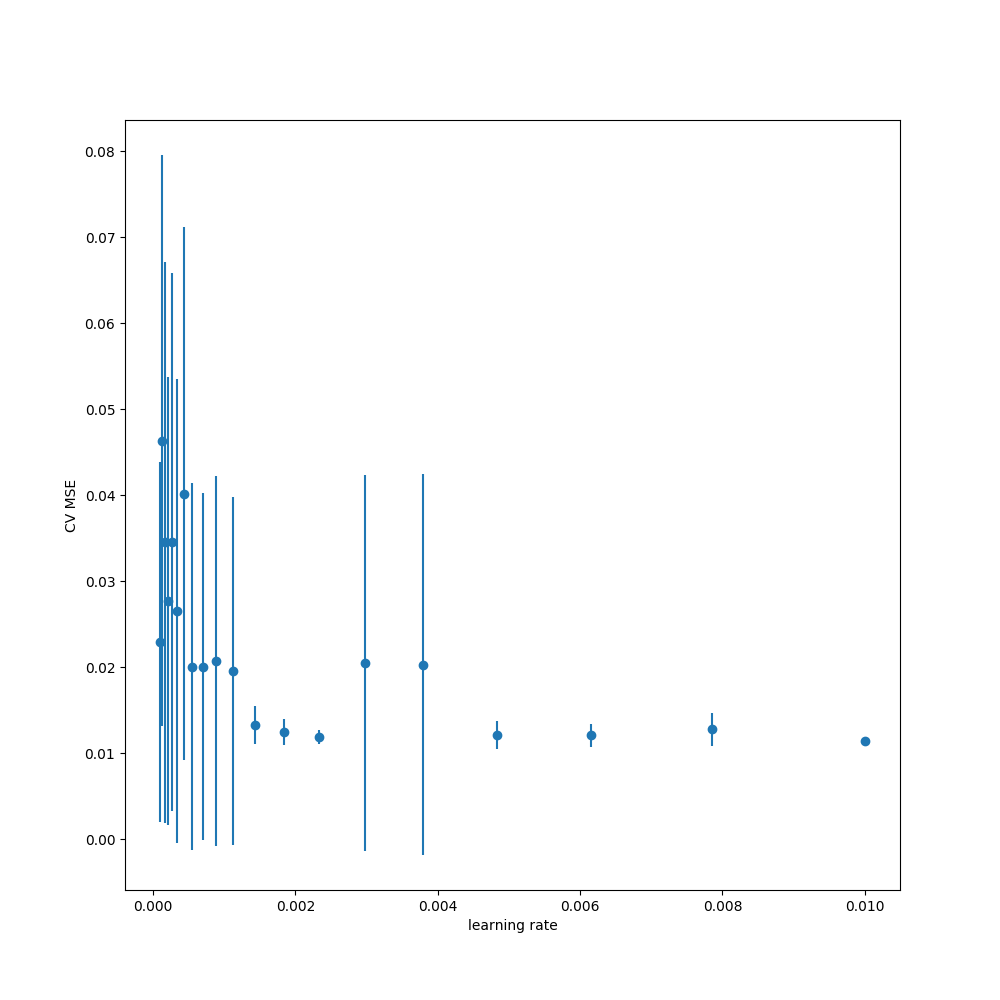

In [84]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))

ax.errorbar(learning_rates, CV_mean_loss, yerr=CV_std_loss, fmt='o')
ax.set_xlabel('learning rate')
ax.set_ylabel('CV MSE')

plt.show()

First note that this grid search took nearly 2 hours, mainly because many very small learning rates were sampled, so many training cycles were inefficient.  In any case, values around 0.005 seem to be nearly optimal.

### Batch Size with Learning Rate

The main effect of learning rate is to change the step size for gradient descent
$$ \mathbf{W} \rightarrow \mathbf{W} -  \alpha \frac{\partial J}{\mathbf{W}}. $$
In stochastic gradient descent (and refinements), we don't use the entire training set to compute the gradient of the  loss function at every step.  Instead we use a random sample, the minibatch, of size given by the batch size hyperparameter.    There are two main reasons for this approximation:
* It is computationally efficient.  The number of computations is $\mathcal{O}(m)$ vs $\mathcal{O}(N)$, but the uncertainty in the gradient scales like  $\mathcal{O}(\sqrt{m})$. So there are diminishing returns to making the batch size $m$ very large.
* The step size scales as $\mathcal{O}(m)$. If the true cost function is very nonlinear, large steps will fail to probe smaller changes in the cost function and could overshoot good local minima.  By controlling the batch size, along with the learning rate, we can control the step size and keep the learning process stable and convergent.

![stepsize](stepsize.png)

For these reasons, it can be best to tune the learning rate together with the batch size, so we'll explore doing this with random search.  

We need to establish probability distributions to sample.  For the learning rate, we want a strictly positive continuous distribution centered near 0.005 with an appropriate width to sample an order of magnitude up or down from this.  The following Maxwell distribution is promising:

<IPython.core.display.Javascript object>


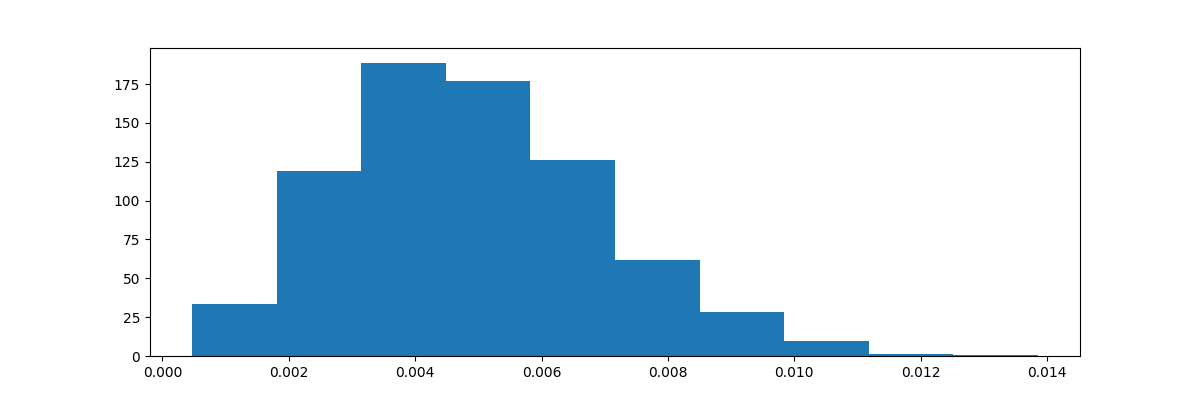

In [85]:
fig, ax = plt.subplots(1)
ax.hist(stats.maxwell(loc=0.0001, scale=0.003).rvs(10000), normed=True)
plt.show()

For the batch size, we want to look for values in the range (20, 500).  We can try another Maxwell distribution:

<IPython.core.display.Javascript object>


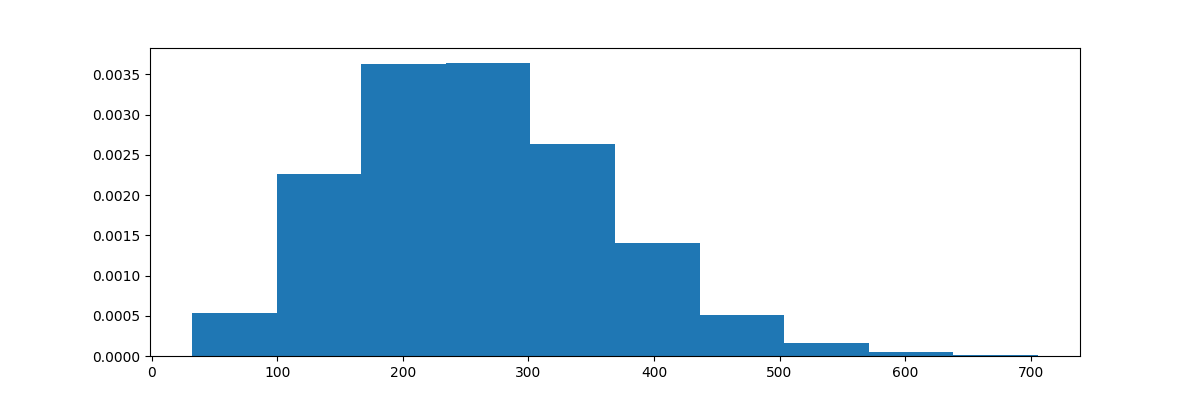

In [86]:
fig, ax = plt.subplots(1)
ax.hist(stats.maxwell(loc=20, scale=150).rvs(10000), normed=True)
plt.show()

A uniform distribution on (20, 500) would probably be another acceptable option.  Putting these together, we define a dictionary containing the parameters and the chosen distributions.

In [87]:
param_grid = {'batch_size': stats.maxwell(loc=20, scale=150), 
              'learning_rate': stats.maxwell(loc=0.0001, scale=0.003), 
              'patience': stats.randint(2, 5)}

To draw samples, it is convenient to use the sklearn function `ParameterSampler`

In [88]:
from sklearn.model_selection import ParameterSampler

param_dict = list(ParameterSampler(param_grid, n_iter=20, random_state=95))
param_dict

[{'batch_size': 182.41534643426689,
  'learning_rate': 0.0035043587194597287,
  'patience': 4},
 {'batch_size': 292.40759933870544,
  'learning_rate': 0.006134784430957072,
  'patience': 2},
 {'batch_size': 101.10895222927643,
  'learning_rate': 0.0041324843859692519,
  'patience': 2},
 {'batch_size': 353.6042149011214,
  'learning_rate': 0.0053140476160841495,
  'patience': 3},
 {'batch_size': 122.07285050828845,
  'learning_rate': 0.0035160820403140882,
  'patience': 3},
 {'batch_size': 275.34566443328731,
  'learning_rate': 0.0058480545733876317,
  'patience': 4},
 {'batch_size': 143.94257000293132,
  'learning_rate': 0.007751785451478547,
  'patience': 3},
 {'batch_size': 232.85600049454291,
  'learning_rate': 0.0046517211689102028,
  'patience': 3},
 {'batch_size': 236.8746722630556,
  'learning_rate': 0.0055191758972598136,
  'patience': 3},
 {'batch_size': 523.75261401463183,
  'learning_rate': 0.0038988018723366854,
  'patience': 2},
 {'batch_size': 272.97222538169063,
  'learn

For convenience, we can convert the list of dictionaries to a list of tuples:

In [102]:
param_list = [list(d.values()) for d in param_dict]
param_list

[[182.41534643426689, 4, 0.0035043587194597287],
 [292.40759933870544, 2, 0.006134784430957072],
 [101.10895222927643, 2, 0.0041324843859692519],
 [353.6042149011214, 3, 0.0053140476160841495],
 [122.07285050828845, 3, 0.0035160820403140882],
 [275.34566443328731, 4, 0.0058480545733876317],
 [143.94257000293132, 3, 0.007751785451478547],
 [232.85600049454291, 3, 0.0046517211689102028],
 [236.8746722630556, 3, 0.0055191758972598136],
 [523.75261401463183, 2, 0.0038988018723366854],
 [272.97222538169063, 3, 0.0044041441371076694],
 [195.8363895586356, 3, 0.0049574910803337844],
 [297.62606303040599, 2, 0.0064098338613170778],
 [138.89059673123961, 4, 0.0033011939944997061],
 [238.06255001157558, 3, 0.0080182650457898217],
 [277.76673343101515, 2, 0.010215756219168856],
 [162.93497265826062, 2, 0.0038615124412814858],
 [185.72015040136233, 4, 0.0030713652011511612],
 [274.82187701270198, 2, 0.0064658502985509604],
 [303.77973511537408, 2, 0.006760385893435499]]

In [103]:
for (batch_size, patience, learning_rate) in param_list:
    print((batch_size, patience, learning_rate))

(182.41534643426689, 4, 0.0035043587194597287)
(292.40759933870544, 2, 0.006134784430957072)
(101.10895222927643, 2, 0.0041324843859692519)
(353.6042149011214, 3, 0.0053140476160841495)
(122.07285050828845, 3, 0.0035160820403140882)
(275.34566443328731, 4, 0.0058480545733876317)
(143.94257000293132, 3, 0.007751785451478547)
(232.85600049454291, 3, 0.0046517211689102028)
(236.8746722630556, 3, 0.0055191758972598136)
(523.75261401463183, 2, 0.0038988018723366854)
(272.97222538169063, 3, 0.0044041441371076694)
(195.8363895586356, 3, 0.0049574910803337844)
(297.62606303040599, 2, 0.0064098338613170778)
(138.89059673123961, 4, 0.0033011939944997061)
(238.06255001157558, 3, 0.0080182650457898217)
(277.76673343101515, 2, 0.010215756219168856)
(162.93497265826062, 2, 0.0038615124412814858)
(185.72015040136233, 4, 0.0030713652011511612)
(274.82187701270198, 2, 0.0064658502985509604)
(303.77973511537408, 2, 0.006760385893435499)


We can use the CV code from before, now modified to iterate over the values in this list of random samples:

In [104]:
import pandas as pd
pd.set_option('display.precision',5)

# training parameters
n_epoch = 1000

# create dataframe to store the parameters and CV scores
results_df = pd.DataFrame(dtype = 'float64')

start = time()

for count, (batch_size, patience, learning_rate) in enumerate(param_list):
    batch_size = int(batch_size)
    (results_df.loc[count, 'batch_size'], 
     results_df.loc[count, 'learning_rate'],
     results_df.loc[count, 'patience']) = (batch_size, learning_rate, patience)
    CVscores = []
    for fold, (train_idx, test_idx) in enumerate(kfold.split(x_train, y_train)):
        # print progress bar
        i = fold + 1
        sys.stdout.write('\r')
        sys.stdout.write("Batch size: " + str(batch_size) +
                         ", Learning rate: " + format(learning_rate, '.5f') + 
                         ", Patience: " + str(patience) +
                         ", training models: " +
                         "[%-10s] %d%%" % ('='*i, 10*i))
        sys.stdout.flush()

        # create model
        model = None # clear any previous model

        optimizer=tf.contrib.keras.optimizers.Adam(lr=learning_rate)
        callbacks = [tf.contrib.keras.callbacks.EarlyStopping(monitor='loss', 
                                                              patience=patience, verbose=0)]

        model =  tf.contrib.keras.models.Sequential()
        model.add(tf.contrib.keras.layers.Dense(units=64, input_dim=n_feat))
        model.add(tf.contrib.keras.layers.Activation('relu'))
        model.add(tf.contrib.keras.layers.Dense(units=1))
        model.compile(loss='mean_squared_error',
                      optimizer=optimizer)
        # Fit to CV train fold
        model.fit(x_train[train_idx], y_train[train_idx], 
                  epochs=n_epoch, batch_size=batch_size, verbose=0,
                  callbacks=callbacks)
        # Evaluate on CV test fold
        score = model.evaluate(x_train[test_idx], y_train[test_idx], 
                               batch_size=batch_size, verbose=0)
        CVscores.append(score)

    CVmean = np.mean(CVscores)
    CVstd = np.std(CVscores)
    print("\n" + "For batch size " + str(batch_size) + 
          ", learning rate: " + format(learning_rate, '.5f') + 
          ", patience: " + str(patience) + 
          ", CV MSE: " + format(CVmean, '.4f') + 
          ", in time: " + format(time() - start, '.2f') + "s" )
    results_df.loc[count, 'CVmean'] = CVmean
    results_df.loc[count, 'CVstd'] = CVstd
print("Complete in " + format(time() - start, '.2f') + "s")

Batch size: 182, Learning rate: 0.00350, Patience: 4, training models: [==========] 100%
For batch size 182, learning rate: 0.00350, patience: 4, CV MSE: 0.0225, in time: 346.55s
Batch size: 292, Learning rate: 0.00613, Patience: 2, training models: [==========] 100%
For batch size 292, learning rate: 0.00613, patience: 2, CV MSE: 0.0183, in time: 566.09s
Batch size: 101, Learning rate: 0.00413, Patience: 2, training models: [==========] 100%
For batch size 101, learning rate: 0.00413, patience: 2, CV MSE: 0.0162, in time: 889.43s
Batch size: 353, Learning rate: 0.00531, Patience: 3, training models: [==========] 100%
For batch size 353, learning rate: 0.00531, patience: 3, CV MSE: 0.0183, in time: 1145.31s
Batch size: 122, Learning rate: 0.00352, Patience: 3, training models: [==========] 100%
For batch size 122, learning rate: 0.00352, patience: 3, CV MSE: 0.0168, in time: 1553.16s
Batch size: 275, Learning rate: 0.00585, Patience: 4, training models: [==========] 100%
For batch size

In [105]:
results_df.sort_values(['CVmean'], ascending=False)

batch_size  learning_rate  patience   CVmean    CVstd
16       162.0        0.00386       2.0  0.04920  0.09321
0        182.0        0.00350       4.0  0.02248  0.01643
15       277.0        0.01022       2.0  0.02088  0.00608
19       303.0        0.00676       2.0  0.02017  0.00498
9        523.0        0.00390       2.0  0.01932  0.00552
18       274.0        0.00647       2.0  0.01878  0.00271
8        236.0        0.00552       3.0  0.01852  0.00656
3        353.0        0.00531       3.0  0.01825  0.00725
1        292.0        0.00613       2.0  0.01825  0.00270
12       297.0        0.00641       2.0  0.01820  0.00382
7        232.0        0.00465       3.0  0.01787  0.00659
14       238.0        0.00802       3.0  0.01747  0.00336
10       272.0        0.00440       3.0  0.01729  0.00280
4        122.0        0.00352       3.0  0.01676  0.00493
17       185.0        0.00307       4.0  0.01658  0.00309
2        101.0        0.00413       2.0  0.01621  0.00290
6        143.0        0.00775       3.0  0.01617  0.00317
11       195.0        0.00496       3.0  0.01557  0.00346
5        275.0        0.00585       4.0  0.01548  0.00426
13       138.0        0.00330       4.0  0.01490  0.00302

The point with `{'batch_size': 138.89059673123961, 'learning_rate': 0.0033011939944997061, 'patience': 4}` results in a CV MSE of around 0.015, which is larger than the best previous results which were around 0.12.  We might choose to drop coverage of patience = 2 combinations in order to sample more combinations that are likely to give the best results. 

This random search took around the same time needed for our grid search of learning rates, but we were able to cover 3 hyperparameters in that time.

Let's look at a 3d plot of the CV MSE:

<IPython.core.display.Javascript object>


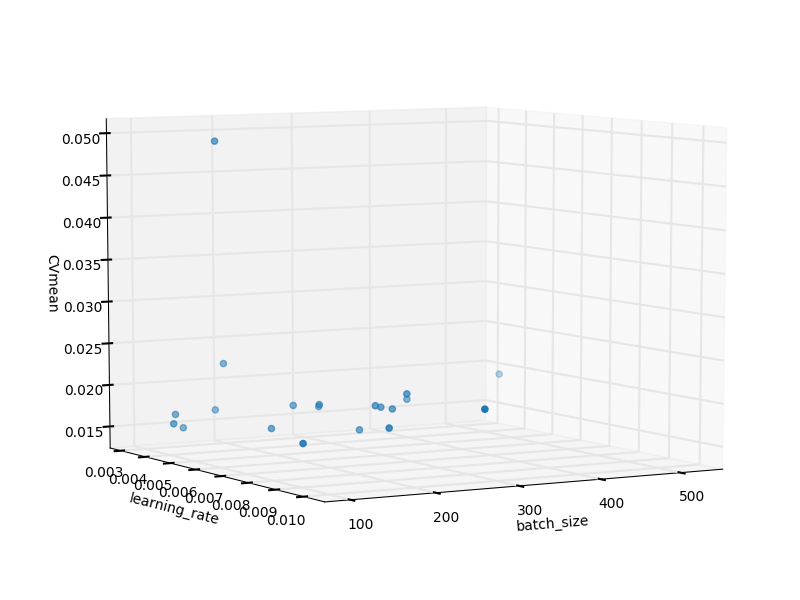

In [111]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

try: 
    if results_df is None:
        results_df = pd.read_csv('CVresults.csv', index_col=0)
except:
    results_df = pd.read_csv('CVresults.csv', index_col=0)

ax.scatter(results_df['batch_size'], results_df['learning_rate'], results_df['CVmean'])

# axes labels
plt.xlabel('batch_size')
plt.ylabel('learning_rate')
ax.set_zlabel('CVmean')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.gca().invert_zaxis()

ax.mouse_init()
plt.show()

One would really need to plot many more points to flesh this picture out, but it does suggest that the loss function is nonconvex as a function of these learning hyperparameters. There are probably many local minima and random search is an efficient way to find a "good-enough" point in a reasonable amount of time.

### Width and Depth Tuning

While incredibly important and interesting, we will delay applying the above techniques to NN architecture to a future presentation.  Some issues to address should the reader want to pursue this:
* One should organize as much of the code as possible into functions or other classes.  In particular, the code to build models could be made into a function that reads in an array of widths and assembles the proper dense model.
* Keras provides a sci-kit learn wrapper https://keras.io/scikit-learn-api/ that is extremely convenient for applying sci-kit learn tools like `GridSearchCV` or `RandomSearchCV` to Keras NNs.  The wrapper also allows kwargs to be used to assign parameters to the model building function, again streamlining some of the code.

Furthermore, one should be cognizant of the way that the number of NN model parameters scale with the depth and width.  Overfit is likely to be a problem if the number of parameters in the model is large compared to the number of degrees of freedom/amount of information stored in the training dataset.   

For our simulated data, we had 20k examples with 20 features, so the upper bound is 400k.  Our NN had 64 new features for (64+1)(20) = 1.3k parameters in the hidden layer and 65 more in the output layer.  Since this is a ratio of 0.003, we really didn't see much overfitting in our plots of the training and test loss.

### Final Caveats

Training NNs, especially deep ones can be difficult at times.  It might be necessary to do some hands-on investigation of the training of a particular model before you can generate reliable distributions to use for random search.   It is also worthwhile to investigate the learning process in some detail for whatever hypers have been output by a random search.

Part of the reason for this is that bad learning hypers can lead to gradients either vanishing or blowing up, even late in training.  After this happens the related weights will no longer update and the model will no longer be training.  When this happens, it can be difficult to tell the difference between the possibilities 
1.  The model has stopped training because it has settled into a local minimum.
2.  The model has stopped training because of a pathological gradient.
Usually a sign that we have case 2 is that the model is far underperforming expectations.  However, case 1 can also lead to a very bad result on metrics if we have too small of a learning rate and get stuck in a poor local minimum.  Therefore it is always good to do some sanity checks and other testing by hand during model development. 

## Using Keras to Construct CNNs 

### CNN on CIFAR-10 Small Image dataset

We will base the following discussion on the `cifar10_cnn.py` example from the Keras examples folder at https://github.com/fchollet/keras/tree/master/examples.  Let's load the data:

In [73]:
(x_train, y_train), (x_test, y_test) = tf.contrib.keras.datasets.cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


<IPython.core.display.Javascript object>


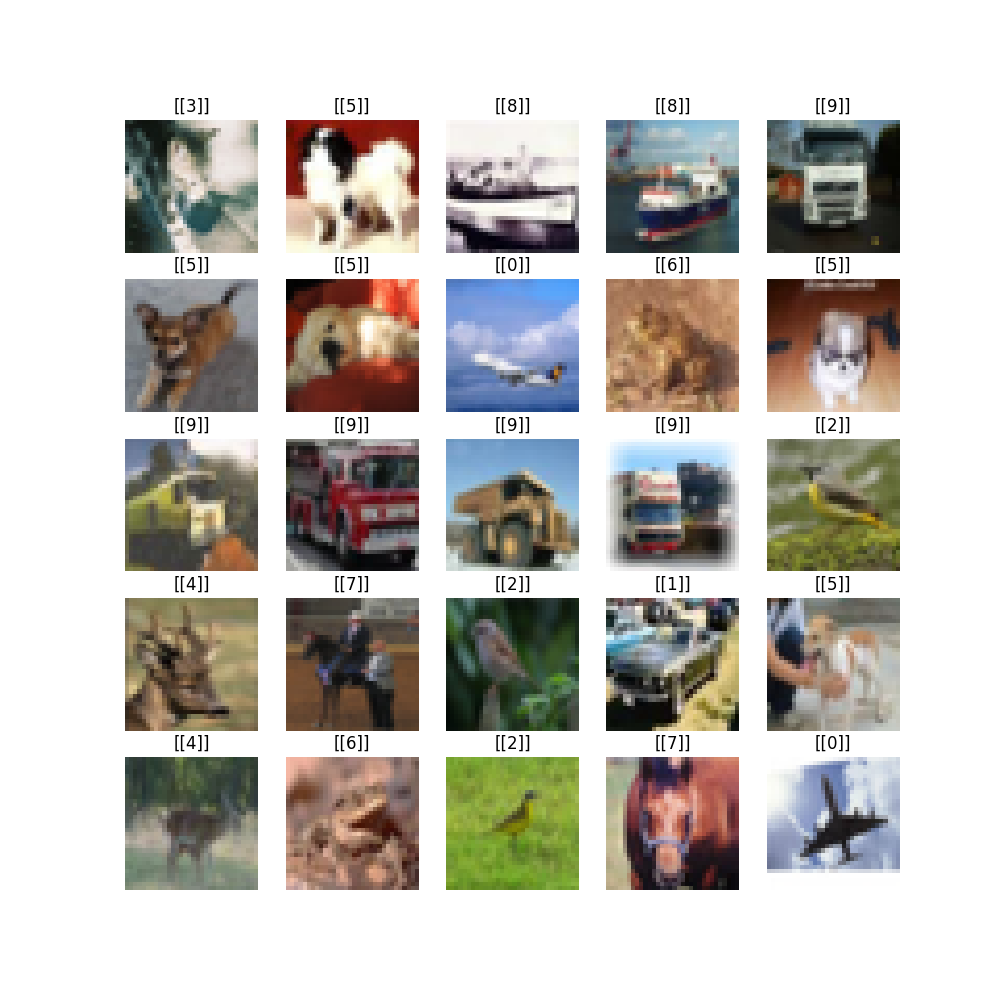

In [74]:
fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(x_train)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(x_train[i:i+1][0])
        axes1[j][k].set_title(y_train[i:i+1])

Actual label classes are:
*   airplane 
*   automobile 
*   bird 
*  cat 
*  deer 
*  dog 
*  frog 
*  horse 
*  ship 
* truck

We can convert the ordinal class labels to one-hot vectors in many ways, but we'll use the appropriate Keras function:

In [75]:
num_classes = 10

y_train = tf.contrib.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.contrib.keras.utils.to_categorical(y_test, num_classes)

In [76]:
y_train[0:10]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

We'll also rescale the inputs

In [77]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

The deep CNN we'll apply to this image classification problem is:

![cnn](cnn.png)

In [78]:
model = None
model = tf.contrib.keras.models.Sequential()

model.add(tf.contrib.keras.layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(tf.contrib.keras.layers.Activation('relu'))
model.add(tf.contrib.keras.layers.Conv2D(32, (3, 3)))
model.add(tf.contrib.keras.layers.Activation('relu'))
model.add(tf.contrib.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.contrib.keras.layers.Dropout(0.25))

model.add(tf.contrib.keras.layers.Conv2D(64, (3, 3), padding='same'))
model.add(tf.contrib.keras.layers.Activation('relu'))
model.add(tf.contrib.keras.layers.Conv2D(64, (3, 3)))
model.add(tf.contrib.keras.layers.Activation('relu'))
model.add(tf.contrib.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.contrib.keras.layers.Dropout(0.25))

model.add(tf.contrib.keras.layers.Flatten())
model.add(tf.contrib.keras.layers.Dense(512))
model.add(tf.contrib.keras.layers.Activation('relu'))
model.add(tf.contrib.keras.layers.Dropout(0.5))
model.add(tf.contrib.keras.layers.Dense(num_classes))
model.add(tf.contrib.keras.layers.Activation('softmax'))

Keras also provides a generator class to do preprocessing and serve minibatches:

In [79]:
datagen = tf.contrib.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

The few options that are turned on here are designed to improve the generalization of the CNN by making it insensitive to small spatial shifts or flips of the input. The generator is designed to be prefit before using it for training:

In [80]:
datagen.fit(x_train)

It is clear from some testing that the learning rate in later rounds should be quite a bit smaller than the learning rate for very early rounds.   Setting the `decay` option, the optimizer reduces the learning rate by a factor of $ 1/(1 + k d)$ for the $k$th minibatch, with decay rate $d$.  The following function can be used to compute the discounted learning rate at the end of later training epochs:

In [81]:
def discounted_learning_rate(learning_rate, decay, epochs, batch_size):
    tot_batch = int(x_train.shape[0] / batch_size)
    discount = 1
    for epoch in range(1, epochs+1):
        discount = 1./(1. + epoch * tot_batch * decay)
        lr = learning_rate * discount
        lr = format(lr, '.7f')
        if (epoch % 5 == 0):
            print(epoch, lr)
        if ((epoch == epochs) and (epoch % 5 != 0)):
            print(epoch, lr)
#         print(epoch, lr)

In [82]:
discounted_learning_rate(0.001, 3 * 1e-4, 28, 64 )

5 0.0004605
10 0.0002991
15 0.0002215
20 0.0001759
25 0.0001458
28 0.0001323


Some testing results in a suitable initial learning rate, decay, and batch size to train the model:

In [83]:
batch_size = 64 
epochs = 28
learning_rate = 0.001
decay = 3 * 1e-4

start = time()

opt = tf.contrib.keras.optimizers.RMSprop(lr=learning_rate, decay=decay)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))
print("Complete in " + format(time() - start, '.2f') + "s")

Epoch 1/28
781/781 [==============================] - 350s - loss: 1.6873 - acc: 0.3824 - val_loss: 1.2663 - val_acc: 0.5445
Epoch 2/28
781/781 [==============================] - 346s - loss: 1.2859 - acc: 0.5387 - val_loss: 1.0868 - val_acc: 0.6123
Epoch 3/28
781/781 [==============================] - 346s - loss: 1.1118 - acc: 0.6056 - val_loss: 0.8873 - val_acc: 0.6939
Epoch 4/28
781/781 [==============================] - 344s - loss: 1.0071 - acc: 0.6440 - val_loss: 0.8428 - val_acc: 0.7080
Epoch 5/28
781/781 [==============================] - 343s - loss: 0.9437 - acc: 0.6684 - val_loss: 0.7959 - val_acc: 0.7227
Epoch 6/28
781/781 [==============================] - 343s - loss: 0.8944 - acc: 0.6869 - val_loss: 0.7321 - val_acc: 0.7503
Epoch 7/28
781/781 [==============================] - 343s - loss: 0.8589 - acc: 0.7018 - val_loss: 0.7053 - val_acc: 0.7551
Epoch 8/28
781/781 [==============================] - 342s - loss: 0.8287 - acc: 0.7108 - val_loss: 0.6948 - val_acc: 0.7629


At around 80% accuracy, this is reasonable for a relatively small network.  It might be possible to come up with better training hyperparameters, but I was unable to do so with the long training times on my CPU.  State of the art results for CIFAR-10 are around 95.5% with CNNs 3-4x as deep as this one, so it's clear that tuning this model probably would only get a few more % accuracy out, which would not be too dramatic of a decrease in the error rate.

## Writing Models to Files

Finally, it's worth pointing out that Keras includes various commands for writing weights and even entire models to disk https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model.  For instance, we can save the current model to a file via:

In [ ]:
model.save('cnn_model1.h5')

We can reload it via

In [ ]:
model = tf.contrib.keras.models.load_model('cnn_model1.h5')

As you might imagine, this can be helpful during training to try different hyperparameters out when the training time is too long to do full CV.